# Estimación y predicción de potencia de panel fotovoltaico
### Elaborada por Fernando Jacome

# Lectura de los archivos CSV

        Irradiancia   temperatura     Potencia 
count  19561.000000  19561.000000  19561.000000
mean     314.944317     19.376409     19.778674
std      422.018172     11.001553     31.083813
min       -0.001000      5.875000      0.000000
25%        0.000000     11.750000      0.000000
50%        9.109000     13.937000      0.919873
75%      714.310000     25.125000     29.434370
max     1100.350000     56.750000    149.965998


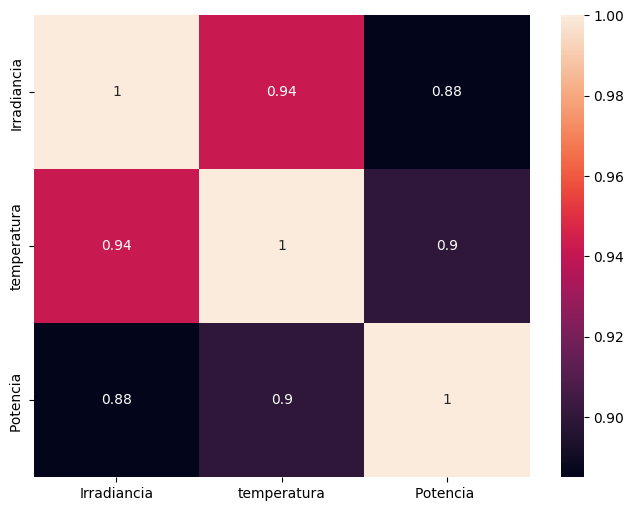

       IrradianciaSolar  temperaturaPanel  relativeHumidity   
count       1636.000000       1636.000000       1636.000000  \
mean         315.814763         19.424891         86.984362   
std          422.485612         11.040991         12.566176   
min           -0.001000          6.188000         45.610960   
25%            0.000000         11.750000         80.765781   
50%           10.950000         14.000000         91.588380   
75%          707.653250         25.125000         96.431628   
max         1099.990000         55.625000        109.889945   

       specificCloudLiquidWaterContent  specificHumidity  temperature   
count                     1.636000e+03       1636.000000  1636.000000  \
mean                      6.552234e-05          0.008952   297.176764   
std                       7.976662e-05          0.000915     0.109854   
min                       0.000000e+00          0.006050   296.834477   
25%                       5.728000e-07          0.008404   297.0954

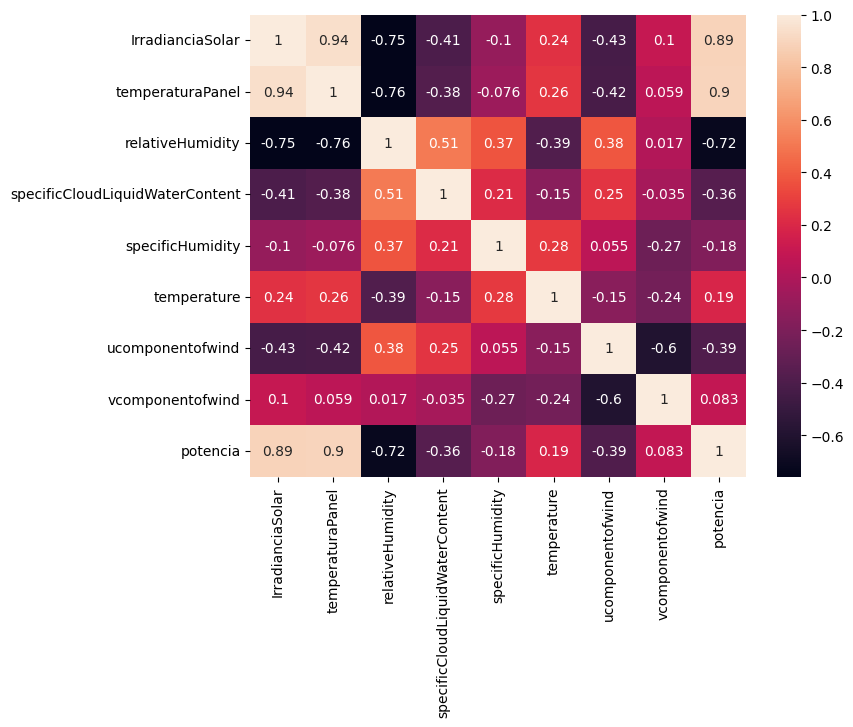

In [40]:
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Pred_DAS = pd.read_csv(r'G:\files\Predictores_DAS.csv')
Predictores_C3S = pd.read_csv(r'G:\files\Predictores_C3S.csv')
Targ_DAS = pd.read_csv(r'G:\files\Target_DAS.csv')
Target_C3S = pd.read_csv(r'G:\files\Target_C3S.csv')

PredTarg_DAS = pd.read_csv(r'G:\files\PredTarg_DAS.csv')
PredTarg_C3S = pd.read_csv(r'G:\files\PredTarg_C3S.csv')

Predictores_DAS = Pred_DAS.to_numpy()
Target_DAS = Targ_DAS.to_numpy()


print(PredTarg_DAS.describe())

corr_PredTarg_DAS = PredTarg_DAS.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_PredTarg_DAS, annot=True)
plt.show()

print(PredTarg_C3S.describe())
corr_PredTarg_C3S = PredTarg_C3S.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_PredTarg_C3S, annot=True)
plt.show()



# Definición de los modelos de Machine Learning a utilizar

In [6]:
import numpy as np

#Librería para algoritmo Random Forest
from sklearn.ensemble import RandomForestRegressor

#Librería para algoritmo SVR
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV

#Librerías para algoritmo MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

#Estandarización y división en conjuntos de train y test
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split


class regressor_ml():
    def __init__(self) -> None:
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X = None
        self.y = None
    def std(self):  #Estandarización de X_train y X_test
        scaler = StandardScaler()
        scaler.fit(self.X_train)
        self.X_train = scaler.transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def rf(self, n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=1, max_features='auto', bootstrap=True):
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap)
        self.model.fit(self.X_train, self.y_train)
        self.model.score(self.X_test, self.y_test)

    def svr(self, kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'):
        self.model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
        self.model.fit(self.X_train, self.y_train)
        self.model.score(self.X_test, self.y_test)
    
    def prediction(self):
        self.y_pred = self.model.predict(self.X_test)
        return self.y_pred
        


In [ ]:
reg = regressor_ml()

# Dividimos el conjunto de datos (predictores y target) en conjuntos de train y test, dedicando un 80% al conjunto de entrenamiento, y un 20% al conjunto de test. 

reg.X_train, reg.X_test, reg.y_train, reg.y_test = train_test_split(Predictores_DAS, Target_DAS , test_size= 0.2 , shuffle= False )
X_train = reg.X_train
X_test = reg.X_test
y_train = reg.y_train
y_test = reg.y_test



#Estandarización de las muestras de entrada de train y test

reg.std()


X_train_std = reg.X_train
X_test_std = reg.X_test
y_train_std = reg.y_train
y_test_std = reg.y_test

# Obtención de los conjuntos de entrenamiento y test, y estandarización de X_train y X_test

### Para ello dedicaremos el 80% de las muestras para el conjunto de entrenamiento, y el 20% restante para el conjunto de test. 

# Busqueda aleatoria de los parametros del modelo RF

In [118]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from time import time
import numpy as np

rf_regressor = RandomForestRegressor()


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

n_iter_search = 10
# Crear el espacio de busqueda de hiper parametros
param_dist = {'n_estimators': np.round(loguniform.rvs(1, 1000, size=n_iter_search)).astype(int),
 'max_depth': np.round(loguniform.rvs(1, 10, size=n_iter_search)).astype(int),
 'min_samples_split': np.round(loguniform.rvs(1, 10, size=n_iter_search)).astype(int),
 'min_samples_leaf': np.round(loguniform.rvs(1, 10, size=n_iter_search)).astype(int),
 'max_features': ['sqrt','log2', 1.0]}

# Correr la busqueda aleatoria

random_search_rf = RandomizedSearchCV(
    rf_regressor, param_distributions=param_dist, n_iter=n_iter_search #,scoring='neg_mean_absolute_error'
)
start = time()
random_search_rf.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."% ((time() - start), n_iter_search))
report(random_search_rf.cv_results_)

c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: Dat

RandomizedSearchCV took 38.27 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.701 (std: 0.372)
Parameters: {'n_estimators': 175, 'min_samples_split': 1, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.699 (std: 0.377)
Parameters: {'n_estimators': 711, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.698 (std: 0.363)
Parameters: {'n_estimators': 119, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 3}



In [119]:
random_search_rf.best_params_

{'n_estimators': 175,
 'min_samples_split': 1,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 3}

# Predicciones con los diferentes modelos: Modelo Random Forest

### Llamada de los diferentes algoritmos de regresión. 

In [120]:

#Predicciones con los diferentes modelos
reg.rf(n_estimators=random_search_rf.best_params_['n_estimators'], max_depth=random_search_rf.best_params_['max_depth'], min_samples_split=random_search_rf.best_params_['min_samples_split'],
        min_samples_leaf=random_search_rf.best_params_['min_samples_leaf'], max_features=random_search_rf.best_params_['max_features'], bootstrap=True) # Random Forest
y_pred_rf = reg.prediction()         # Predicción con Random Forest

y_test = y_test.flatten() #flatten convierte vector a 1D para evitar problemas en el ploteo de las imágenes

y_pred_rf[y_pred_rf < 0] = 0
y_pred_rf = y_pred_rf.flatten()

C:\Users\Fernando Jacome\AppData\Local\Temp\ipykernel_26716\1869955307.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(self.X_train, self.y_train)


# Obtención de las métricas, Scatter plot y grafico temporal para Random Forest

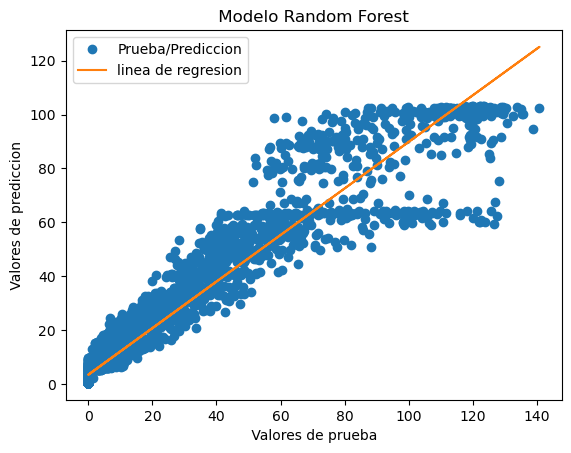

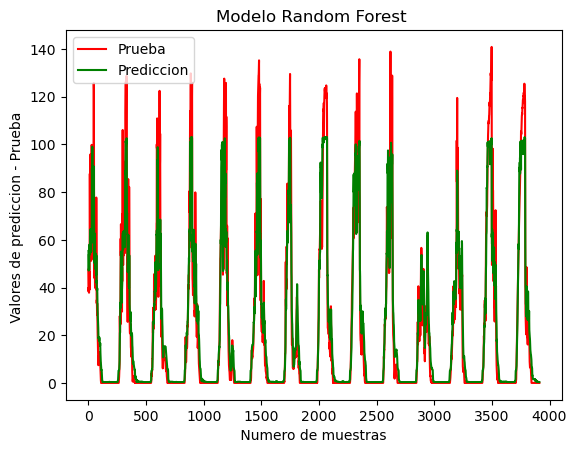

In [121]:
from sklearn import metrics
import matplotlib.pyplot as plt

## Metrics

mtrc = {
    'MAE': lambda y_true, y_pred: metrics.mean_absolute_error(y_true, y_pred), 
    'MSE': lambda y_true, y_pred: metrics.mean_squared_error(y_true, y_pred),
    'r2': lambda y_true, y_pred: metrics.r2_score(y_true, y_pred)
}

MAE_RF = mtrc['MAE'](reg.y_test, y_pred_rf)

MSE_RF = mtrc['MSE'](reg.y_test, y_pred_rf)

r2_RF = mtrc['r2'](reg.y_test, y_pred_rf)



## Scatter plots y predicción temporal

## RF
#Scatterplot
plt.plot(y_test, y_pred_rf , 'o') # Visualizacion del valor predecido y del valorde test
# Obtencion de la línea de regresión del scatterplot (pendiente e intercepto)
m, b = np.polyfit(y_test, y_pred_rf, 1)
#La siguiente línea de código se añade la línea de regresión lineal al scatterplot 
plt.plot(y_test, m*y_test+b)
plt.xlabel(' Valores de prueba ')   
plt.ylabel(' Valores de prediccion ')
plt.title(' Modelo Random Forest ')
plt.legend (["Prueba/Prediccion", "linea de regresion"], loc="best", facecolor="w", fontsize=10)              
plt.show()


#Predicción temporal
plt.plot(y_test,c='r')
plt.plot(y_pred_rf,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title('Modelo Random Forest ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()

In [122]:
print(f'MAE: {MAE_RF}')
print(f'MSE: {MSE_RF}')
print(f'r2: {r2_RF}')

MAE: 4.9877657218134726
MSE: 85.02935977509206
r2: 0.9223628418642681


# Busqueda aleatoria de los parametros del modelo SVR

In [5]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from time import time

svr_regressor = SVR()


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")



# Crear espacio de busqueda de Hiperparametros
param_dist = {'C': loguniform(1e0, 1e3),
 'gamma': loguniform(1e-4, 1e-3),
 'epsilon': loguniform(1e-2, 1e-1),
 'kernel': ['rbf', 'sigmoid']}

# Correr la busqueda aleatoria
n_iter_search = 10
random_search = RandomizedSearchCV(
    svr_regressor, param_distributions=param_dist, n_iter=n_iter_search #,scoring='neg_mean_absolute_error'
)
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."% ((time() - start), n_iter_search))
report(random_search.cv_results_)

c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

RandomizedSearchCV took 569.53 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.720 (std: 0.382)
Parameters: {'C': 25.962354548327276, 'epsilon': 0.052778279893185454, 'gamma': 0.00011413316878439633, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.704 (std: 0.406)
Parameters: {'C': 486.3229374508205, 'epsilon': 0.0323220379878383, 'gamma': 0.00027509058494919495, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.700 (std: 0.406)
Parameters: {'C': 370.7549110452532, 'epsilon': 0.07635301672853326, 'gamma': 0.0004076788034353195, 'kernel': 'rbf'}



In [6]:
random_search.best_params_

{'C': 25.962354548327276,
 'epsilon': 0.052778279893185454,
 'gamma': 0.00011413316878439633,
 'kernel': 'rbf'}

# Predicciones con los diferentes modelos: SVR

In [7]:
#Predicciones con los diferentes modelos
reg.svr(kernel=random_search.best_params_['kernel'], C=random_search.best_params_['C'], epsilon=random_search.best_params_['epsilon'], gamma=random_search.best_params_['gamma'])                # Support Vector Machine for Regression
y_pred_svr = reg.prediction()          #  Predicción con Support Vector Machine for Regression

y_test = y_test.flatten() #flatten convierte vector a 1D para evitar problemas en el ploteo de las imágenes

y_pred_svr[y_pred_svr < 0] = 0
y_pred_svr = y_pred_svr.flatten()

c:\Users\Fernando Jacome\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Obtención de las métricas, Scatter plot y grafico temporal para SVR
Las métricas seran: MAE, MSE y r^2

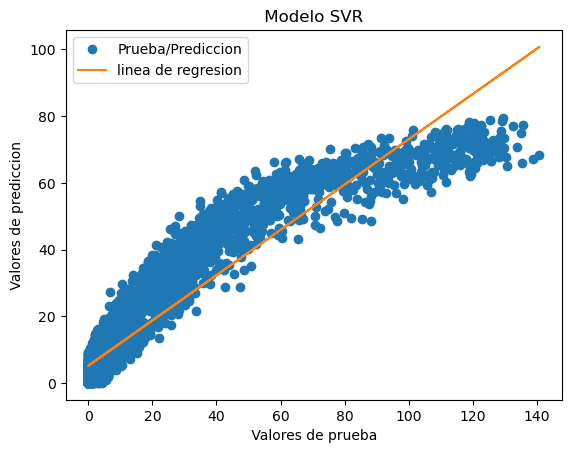

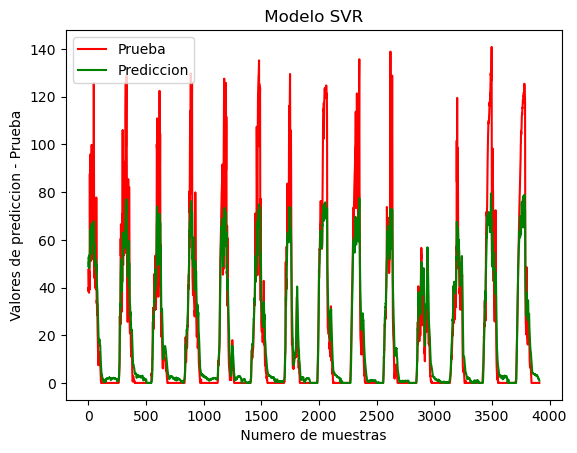

In [113]:
from sklearn import metrics
import matplotlib.pyplot as plt

mtrc = {
    'MAE': lambda y_true, y_pred: metrics.mean_absolute_error(y_true, y_pred), 
    'MSE': lambda y_true, y_pred: metrics.mean_squared_error(y_true, y_pred),
    'r2': lambda y_true, y_pred: metrics.r2_score(y_true, y_pred)
}

MAE_SVR = mtrc['MAE'](reg.y_test, y_pred_svr)

MSE_SVR = mtrc['MSE'](reg.y_test, y_pred_svr)

r2_SVR = mtrc['r2'](reg.y_test, y_pred_svr)

## Scatter plots y predicción temporal

## SVR
#Sscatterplot
plt.plot( y_test, y_pred_svr , 'o')  # Visualizacion del valor predecido y del valorde test
# Obtencion de la línea de regresión del scatterplot (pendiente e intercepto)
m, b = np.polyfit(y_test, y_pred_svr, 1)
#La siguiente línea de código se añade la línea de regresión lineal al scatterplot 
plt.plot(y_test, m*y_test+b)
plt.xlabel(' Valores de prueba ')   
plt.ylabel(' Valores de prediccion ') 
plt.title(' Modelo SVR ')
plt.legend (["Prueba/Prediccion", "linea de regresion"], loc="best", facecolor="w", fontsize=10)                
plt.show()

#Predicción temporal
plt.plot(y_test,c='r')
plt.plot(y_pred_svr,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba ') 
plt.title(' Modelo SVR ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)                  
plt.show()

In [114]:
print(f'MAE: {MAE_SVR}')
print(f'MSE: {MSE_SVR}')
print(f'r2: {r2_SVR}')

MAE: 6.86568607576027
MSE: 175.98088717388535
r2: 0.8393183718832659


In [29]:
# Carga de la extension para tensordoard
%load_ext tensorboard

# Busqueda de hyperparametros con el modelo: MLP

In [38]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime, os

def build_regressor_mpl(hp):
    model = keras.Sequential()
    model.add(layers.Input(X_train_std.shape[1], 1)) 
     # Se escoge el numero de capas
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model


build_regressor_mpl(keras_tuner.HyperParameters())

tuner_mpl = keras_tuner.RandomSearch(
    hypermodel=build_regressor_mpl,
    objective="val_mean_absolute_error",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="dir_mpl",
    project_name="mpl_training",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard("/mpl/tb_logs", histogram_freq=1)

tuner_mpl.search(X_train_std, y_train_std, validation_data=(X_test_std, y_test_std), batch_size=32, epochs=100, verbose=True, callbacks=[keras.callbacks.TensorBoard("/mpl/tb_logs")] )

tuner_mpl.search_space_summary()






Trial 3 Complete [00h 33m 00s]
val_mean_absolute_error: 4.257011413574219

Best val_mean_absolute_error So Far: 4.257011413574219
Total elapsed time: 00h 44m 26s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'li

In [40]:
tuner_mpl.results_summary()


Results summary
Results in dir_mpl\mpl_training
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 2 summary
Hyperparameters:
num_layers: 7
units_0: 288
activation: relu
dropout: False
lr: 0.0059466526991568515
units_1: 288
units_2: 288
units_3: 160
units_4: 480
units_5: 96
units_6: 320
units_7: 448
Score: 4.257011413574219

Trial 0 summary
Hyperparameters:
num_layers: 5
units_0: 480
activation: relu
dropout: True
lr: 0.00021609690906199976
units_1: 32
units_2: 32
units_3: 32
units_4: 32
Score: 4.682257652282715

Trial 1 summary
Hyperparameters:
num_layers: 8
units_0: 416
activation: relu
dropout: True
lr: 0.008653075893754076
units_1: 512
units_2: 480
units_3: 32
units_4: 352
units_5: 32
units_6: 32
units_7: 32
Score: 4.756253242492676


In [41]:
# Se obtiene los 2 mejores modelos encontrados
models_mpl = tuner_mpl.get_best_models(num_models=2)
best_model_mpl = models_mpl[0]
# Ejecuta el modelo
best_model_mpl.build(input_shape=(None, 28, 28))
best_model_mpl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 288)                  864       
                                                                 
 dense_1 (Dense)             (1, 288)                  83232     
                                                                 
 dense_2 (Dense)             (1, 288)                  83232     
                                                                 
 dense_3 (Dense)             (1, 160)                  46240     
                                                                 
 dense_4 (Dense)             (1, 480)                  77280     
                                                                 
 dense_5 (Dense)             (1, 96)                   46176     
                                                                 
 dense_6 (Dense)             (1, 320)                  3

In [ ]:
%tensorboard --logdir "/mpl/tb_logs"

# Predicciones con el mejor modelo encontrado: MLP clasica

In [48]:
y_pred_mlp = best_model_mpl.predict(X_test_std)
y_pred_mlp[y_pred_mlp < 0] = 0 

y_test = y_test.flatten() #flatten convierte vector a 1D para evitar problemas en el ploteo de las imágenes
y_pred_mlp = y_pred_mlp.flatten()

123/123 [==============================] - 0s 2ms/step


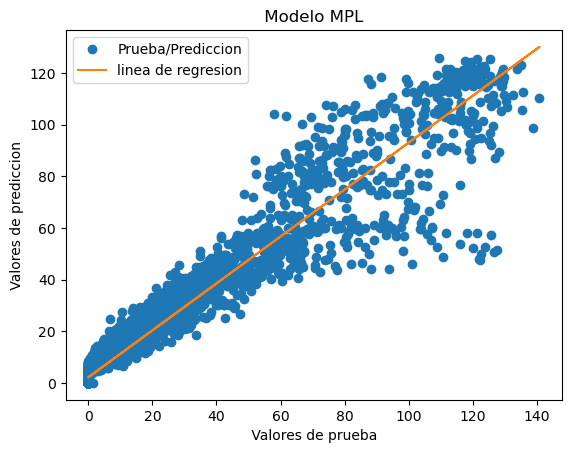

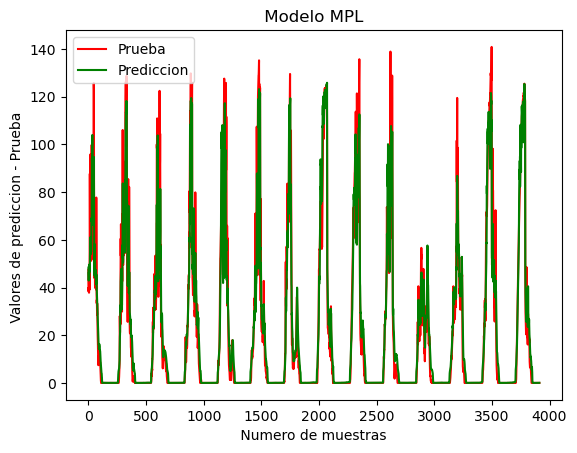

In [49]:
# Obtención de las métricas, Scatter plot y grafico temporal para MPL
# Las métricas seran: MAE, MSE y r^2
from sklearn import metrics
import matplotlib.pyplot as plt

mtrc = {
    'MAE': lambda y_true, y_pred: metrics.mean_absolute_error(y_true, y_pred), 
    'MSE': lambda y_true, y_pred: metrics.mean_squared_error(y_true, y_pred),
    'r2': lambda y_true, y_pred: metrics.r2_score(y_true, y_pred)
}


MAE_MLP = mtrc['MAE'](y_test, y_pred_mlp)

MSE_MLP = mtrc['MSE'](y_test, y_pred_mlp)

r2_MLP = mtrc['r2'](y_test, y_pred_mlp)


## MLP
#Sscatterplot
plt.plot( y_test, y_pred_mlp , 'o')  # Visualizacion del valor predecido y del valorde test
# Obtencion de la línea de regresión del scatterplot (pendiente e intercepto)
m, b = np.polyfit(y_test, y_pred_mlp, 1)
#La siguiente línea de código añade la línea de regresión lineal al scatterplot 
plt.plot(y_test, m*y_test+b)
plt.xlabel(' Valores de prueba ')   
plt.ylabel(' Valores de prediccion ') 
plt.title(' Modelo MPL ')
plt.legend (["Prueba/Prediccion", "linea de regresion"], loc="best", facecolor="w", fontsize=10)         
plt.show()

#Predicción temporal
plt.plot(y_test ,c='r')
plt.plot(y_pred_mlp ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo MPL ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()



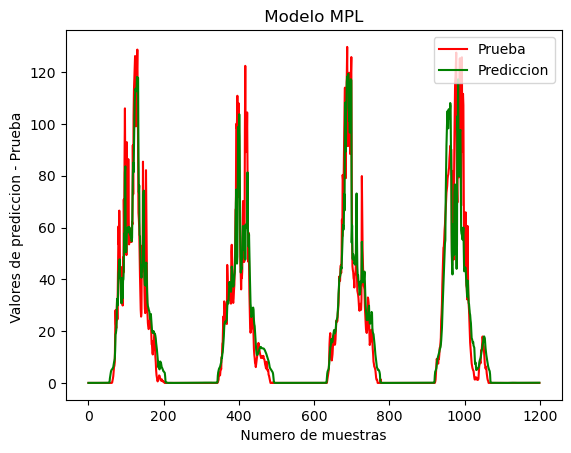

In [50]:
y_test_par = y_test[200:1400]
y_pred_mlp_par = y_pred_mlp[200:1400]


#Predicción temporal
plt.plot(y_test_par ,c='r')
plt.plot(y_pred_mlp_par ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo MPL ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()


In [52]:
print(f'MAE: {MAE_MLP}')
print(f'MSE: {MSE_MLP}')
print(f'r2: {r2_MLP}')

MAE: 4.201384695935391
MSE: 76.33535751373489
r2: 0.9303010132227583


# Busqueda de hyperparametros con el modelo: RNN

In [25]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime, os

def build_regressor_rnn(hp):
    model = keras.Sequential()
    #model.add(layers.Input(X_train_std.shape[1], 1)) 

    # Se escoge el numero de capas
    for i in range(hp.Int("num_layers", 1, 1)):
        model.add(
            layers.SimpleRNN(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
                input_shape = (X_train_std.shape[1], 1)
            )
        )

    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1))
  
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model


build_regressor_rnn(keras_tuner.HyperParameters())

tuner_rnn = keras_tuner.RandomSearch(
    hypermodel=build_regressor_rnn,
    objective="val_mean_absolute_error",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="dir_rnn",
    project_name="rnn_training",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard("/rnn/tb_logs", histogram_freq=1)

tuner_rnn.search(X_train_std, y_train_std, validation_data=(X_test_std, y_test_std), batch_size=32, epochs=100, verbose=True, callbacks=[keras.callbacks.TensorBoard("/rnn/tb_logs")] )

tuner_rnn.search_space_summary()






Trial 3 Complete [00h 05m 33s]
val_mean_absolute_error: 4.425755262374878

Best val_mean_absolute_error So Far: 4.251159429550171
Total elapsed time: 00h 27m 51s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [26]:
tuner_rnn.results_summary()


Results summary
Results in dir_rnn\rnn_training
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 1 summary
Hyperparameters:
num_layers: 1
units_0: 320
activation: relu
dropout: True
lr: 0.0001545783809235739
Score: 4.251159429550171

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 352
activation: relu
dropout: True
lr: 0.001963607784407455
Score: 4.266246557235718

Trial 2 summary
Hyperparameters:
num_layers: 1
units_0: 96
activation: tanh
dropout: True
lr: 0.005579936781430615
Score: 4.425755262374878


In [32]:
# Se obtiene los 2 mejores modelos encontrados
models_rnn = tuner_rnn.get_best_models(num_models=2)
best_model_rnn = models_rnn[0]
# Ejecuta el modelo
best_model_rnn.build(input_shape=(None, 28, 28))
best_model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 320)               103040    
                                                                 
 dense (Dense)               (None, 320)               102720    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 321       
                                                                 
Total params: 206,081
Trainable params: 206,081
Non-trainable params: 0
_________________________________________________________________


In [33]:
%tensorboard --logdir "/rnn/tb_logs"

Launching TensorBoard...

# Predicciones con el mejor modelo encontrado: Recurrent NN

In [37]:
y_pred_rnn = best_model_rnn.predict(X_test_std)
y_pred_rnn[y_pred_rnn < 0] = 0 

y_test = y_test.flatten() #flatten convierte vector a 1D para evitar problemas en el ploteo de las imágenes
y_pred_rnn = y_pred_rnn.flatten()

123/123 [==============================] - 0s 3ms/step


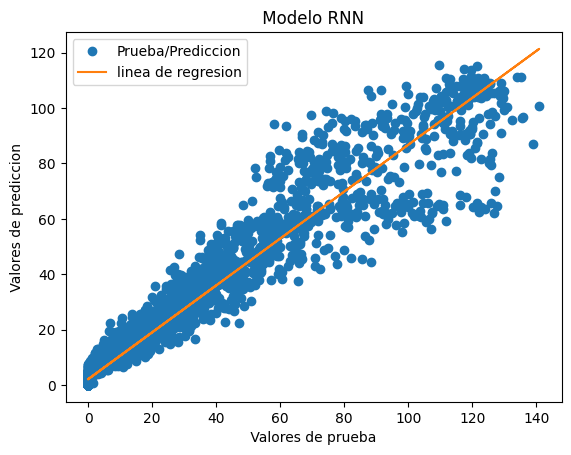

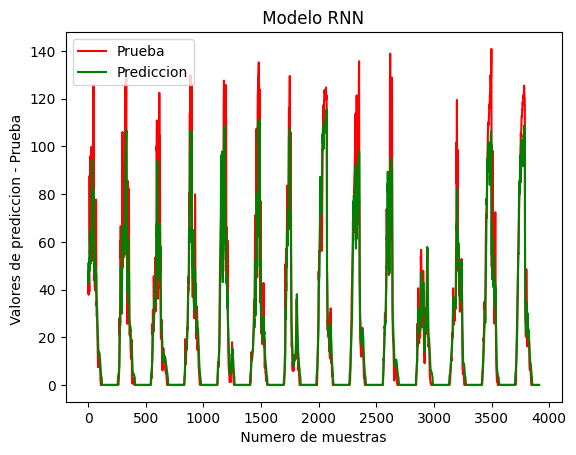

In [38]:
# Obtención de las métricas, Scatter plot y grafico temporal para MPL
# Las métricas seran: MAE, MSE y r^2
from sklearn import metrics
import matplotlib.pyplot as plt

mtrc = {
    'MAE': lambda y_true, y_pred: metrics.mean_absolute_error(y_true, y_pred), 
    'MSE': lambda y_true, y_pred: metrics.mean_squared_error(y_true, y_pred),
    'r2': lambda y_true, y_pred: metrics.r2_score(y_true, y_pred)
}


MAE_RNN = mtrc['MAE'](y_test, y_pred_rnn)

MSE_RNN = mtrc['MSE'](y_test, y_pred_rnn)

r2_RNN = mtrc['r2'](y_test, y_pred_rnn)


## rnn
#Sscatterplot
plt.plot( y_test, y_pred_rnn , 'o')  # Visualizacion del valor predecido y del valorde test
# Obtencion de la línea de regresión del scatterplot (pendiente e intercepto)
m, b = np.polyfit(y_test, y_pred_rnn, 1)
#La siguiente línea de código añade la línea de regresión lineal al scatterplot 
plt.plot(y_test, m*y_test+b)
plt.xlabel(' Valores de prueba ')   
plt.ylabel(' Valores de prediccion ') 
plt.title(' Modelo RNN ')
plt.legend (["Prueba/Prediccion", "linea de regresion"], loc="best", facecolor="w", fontsize=10)         
plt.show()

#Predicción temporal
plt.plot(y_test ,c='r')
plt.plot(y_pred_rnn ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo RNN ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()



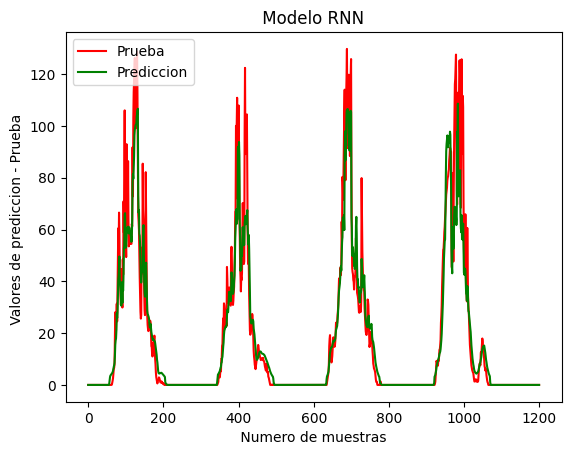

In [40]:
y_test_par = y_test[200:1400]
y_pred_rnn_par = y_pred_rnn[200:1400]


#Predicción temporal
plt.plot(y_test_par ,c='r')
plt.plot(y_pred_rnn_par ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo RNN ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()


In [41]:
print(f'MAE: {MAE_RNN}')
print(f'MSE: {MSE_RNN}')
print(f'r2: {r2_RNN}')

MAE: 4.133877264415261
MSE: 76.68083266465032
r2: 0.9299855726620563


# Predicciones con los diferentes modelos: Long Short Term Memory

# Busqueda de hyperparametros con el modelo: LSTM

In [6]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime, os

def build_regressor_lstm(hp):
    model = keras.Sequential()
    #model.add(layers.Input(X_train_std.shape[1], 1)) 

    # Se escoge el numero de capas
    for i in range(hp.Int("num_layers", 1, 1)):
        model.add(
            layers.LSTM(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
                input_shape = (X_train_std.shape[1], 1)
            )
        )

    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1))
  
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model


build_regressor_lstm(keras_tuner.HyperParameters())

tuner_lstm = keras_tuner.RandomSearch(
    hypermodel=build_regressor_lstm,
    objective="val_mean_absolute_error",
    max_trials=2,
    executions_per_trial=2,
    overwrite=True,
    directory="dir_lstm",
    project_name="lstm_training",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard("/lstm/tb_logs", histogram_freq=1)

tuner_lstm.search(X_train_std, y_train_std, validation_data=(X_test_std, y_test_std), batch_size=32, epochs=100, verbose=True, callbacks=[keras.callbacks.TensorBoard("/lstm/tb_logs")] )

tuner_lstm.search_space_summary()






Trial 2 Complete [00h 07m 47s]
val_mean_absolute_error: 4.474030494689941

Best val_mean_absolute_error So Far: 4.347266912460327
Total elapsed time: 00h 40m 25s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [7]:
tuner_lstm.results_summary()


Results summary
Results in dir_lstm\lstm_training
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 480
activation: tanh
dropout: False
lr: 0.0006629053703185273
Score: 4.347266912460327

Trial 1 summary
Hyperparameters:
num_layers: 1
units_0: 128
activation: relu
dropout: True
lr: 0.000488745888392757
Score: 4.474030494689941


In [8]:
# Se obtiene los 2 mejores modelos encontrados
models_lstm = tuner_lstm.get_best_models(num_models=2)
best_model_lstm = models_lstm[0]
# Ejecuta el modelo
best_model_lstm.build(input_shape=(None, 28, 28))
best_model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 480)               925440    
                                                                 
 dense (Dense)               (None, 480)               230880    
                                                                 
 dense_1 (Dense)             (None, 1)                 481       
                                                                 
Total params: 1,156,801
Trainable params: 1,156,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir "/lstm/tb_logs"

# Predicciones con el mejor modelo encontrado: Long Short Memory NN

In [9]:
y_pred_lstm = best_model_lstm.predict(X_test_std)
y_pred_lstm[y_pred_lstm < 0] = 0 

y_test = y_test.flatten() #flatten convierte vector a 1D para evitar problemas en el ploteo de las imágenes
y_pred_lstm = y_pred_lstm.flatten()

123/123 [==============================] - 1s 6ms/step


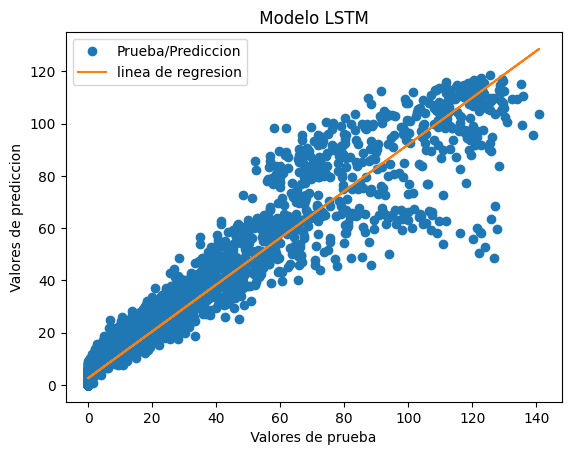

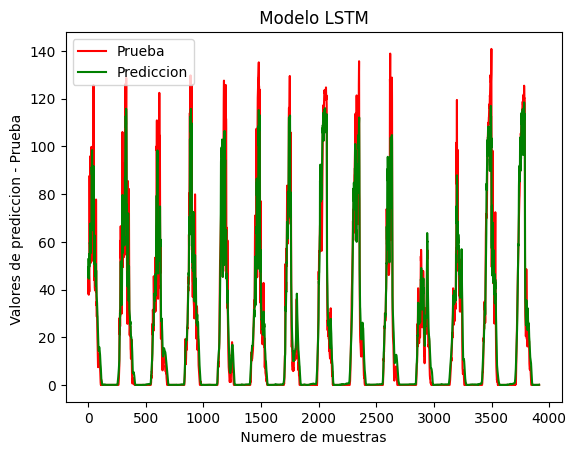

In [11]:
# Obtención de las métricas, Scatter plot y grafico temporal para MPL
# Las métricas seran: MAE, MSE y r^2
from sklearn import metrics
import matplotlib.pyplot as plt

mtrc = {
    'MAE': lambda y_true, y_pred: metrics.mean_absolute_error(y_true, y_pred), 
    'MSE': lambda y_true, y_pred: metrics.mean_squared_error(y_true, y_pred),
    'r2': lambda y_true, y_pred: metrics.r2_score(y_true, y_pred)
}


MAE_LSTM = mtrc['MAE'](y_test, y_pred_lstm)

MSE_LSTM = mtrc['MSE'](y_test, y_pred_lstm)

r2_LSTM = mtrc['r2'](y_test, y_pred_lstm)


## rnn
#Sscatterplot
plt.plot( y_test, y_pred_lstm , 'o')  # Visualizacion del valor predecido y del valorde test
# Obtencion de la línea de regresión del scatterplot (pendiente e intercepto)
m, b = np.polyfit(y_test, y_pred_lstm, 1)
#La siguiente línea de código añade la línea de regresión lineal al scatterplot 
plt.plot(y_test, m*y_test+b)
plt.xlabel(' Valores de prueba ')   
plt.ylabel(' Valores de prediccion ') 
plt.title(' Modelo LSTM ')
plt.legend (["Prueba/Prediccion", "linea de regresion"], loc="best", facecolor="w", fontsize=10)         
plt.show()

#Predicción temporal
plt.plot(y_test ,c='r')
plt.plot(y_pred_lstm ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo LSTM ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()



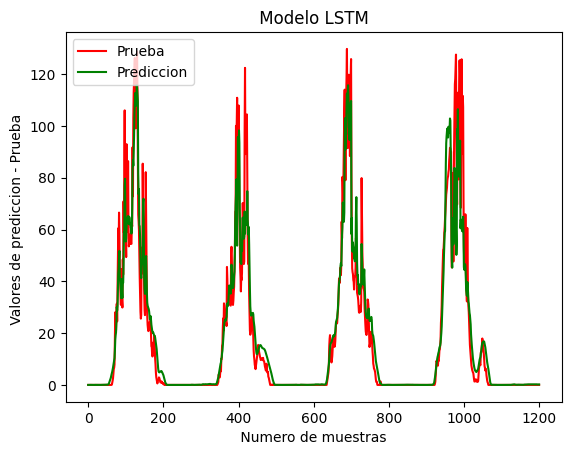

In [12]:
y_test_par = y_test[200:1400]
y_pred_lstm_par = y_pred_lstm[200:1400]


#Predicción temporal
plt.plot(y_test_par ,c='r')
plt.plot(y_pred_lstm_par ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo LSTM ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()


In [13]:
print(f'MAE: {MAE_LSTM}')
print(f'MSE: {MSE_LSTM}')
print(f'r2: {r2_LSTM}')

MAE: 4.278864127000998
MSE: 73.24546691696081
r2: 0.9331222778485109


# Predicciones con los diferentes modelos: Stacked Long Short Term Memory

# Busqueda de hyperparametros con el modelo: SLSTM

In [14]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime, os

def build_regressor_slstm(hp):
    model = keras.Sequential()

    for i in range(hp.Int("num_layers", 1, 1)):
        model.add(
            layers.LSTM(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
                return_sequences=True,
                input_shape = (X_train_std.shape[1], 1)
            )
        )

    # Se escoge el numero de capas
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.LSTM(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
                return_sequences=True
            )
        )

    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1))
  
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model


build_regressor_slstm(keras_tuner.HyperParameters())

tuner_slstm = keras_tuner.RandomSearch(
    hypermodel=build_regressor_slstm,
    objective="val_mean_absolute_error",
    max_trials=2,
    executions_per_trial=2,
    overwrite=True,
    directory="dir_slstm",
    project_name="slstm_training",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard("/slstm/tb_logs", histogram_freq=1)

tuner_slstm.search(X_train_std, y_train_std, validation_data=(X_test_std, y_test_std), batch_size=32, epochs=100, verbose=True, callbacks=[keras.callbacks.TensorBoard("/slstm/tb_logs")] )

tuner_slstm.search_space_summary()






Trial 2 Complete [00h 14m 46s]
val_mean_absolute_error: 4.6348137855529785

Best val_mean_absolute_error So Far: 4.6348137855529785
Total elapsed time: 00h 20m 39s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [15]:
tuner_slstm.results_summary()


Results summary
Results in dir_slstm\slstm_training
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 1 summary
Hyperparameters:
num_layers: 1
units_0: 96
activation: relu
dropout: True
lr: 0.00034246462614677994
Score: 4.6348137855529785

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 64
activation: relu
dropout: False
lr: 0.0007671867010789074
Score: 4.687685966491699


In [20]:
# Se obtiene los 2 mejores modelos encontrados
models_slstm = tuner_slstm.get_best_models(num_models=2)
best_model_slstm = models_slstm[0]
# Ejecuta el modelo
best_model_slstm.build(input_shape=(None, 28, 28))
best_model_slstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 96)             37632     
                                                                 
 lstm_1 (LSTM)               (None, 2, 96)             74112     
                                                                 
 dense (Dense)               (None, 2, 96)             9312      
                                                                 
 dropout (Dropout)           (None, 2, 96)             0         
                                                                 
 dense_1 (Dense)             (None, 2, 1)              97        
                                                                 
Total params: 121,153
Trainable params: 121,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir "/slstm/tb_logs"

# Predicciones con el mejor modelo encontrado: Stacked Long Short Memory NN

In [31]:
y_pred_slstm = best_model_slstm.predict(X_test_std)
y_pred_slstm[y_pred_slstm < 0] = 0 

y_test = y_test.flatten() #flatten convierte vector a 1D para evitar problemas en el ploteo de las imágenes
y_pred_slstm = y_pred_slstm[:,0,0].flatten()

  1/123 [..............................] - ETA: 5s

123/123 [==============================] - 1s 7ms/step


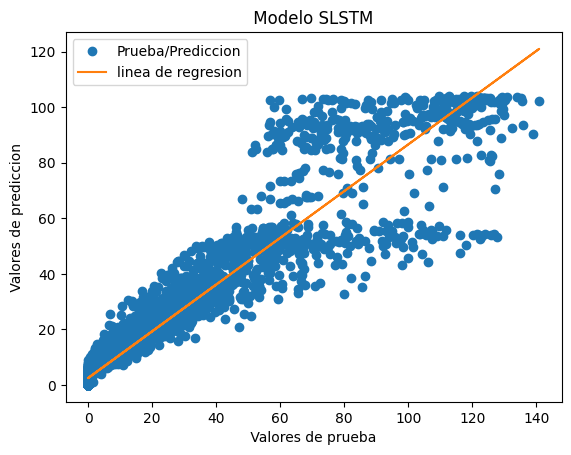

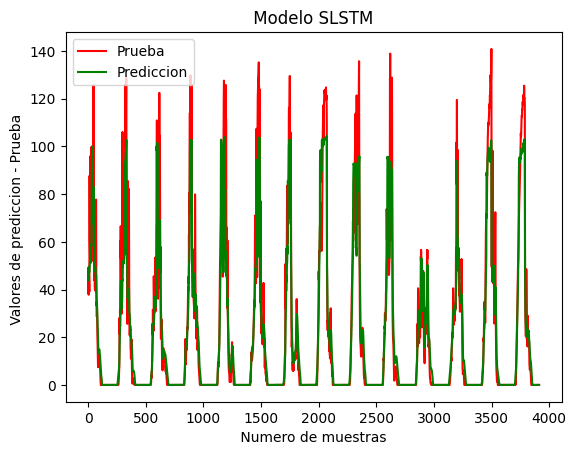

In [32]:
# Obtención de las métricas, Scatter plot y grafico temporal para MPL
# Las métricas seran: MAE, MSE y r^2
from sklearn import metrics
import matplotlib.pyplot as plt

mtrc = {
    'MAE': lambda y_true, y_pred: metrics.mean_absolute_error(y_true, y_pred), 
    'MSE': lambda y_true, y_pred: metrics.mean_squared_error(y_true, y_pred),
    'r2': lambda y_true, y_pred: metrics.r2_score(y_true, y_pred)
}


MAE_SLSTM = mtrc['MAE'](y_test, y_pred_slstm)

MSE_SLSTM = mtrc['MSE'](y_test, y_pred_slstm)

r2_SLSTM = mtrc['r2'](y_test, y_pred_slstm)


## rnn
#Sscatterplot
plt.plot( y_test, y_pred_slstm , 'o')  # Visualizacion del valor predecido y del valorde test
# Obtencion de la línea de regresión del scatterplot (pendiente e intercepto)
m, b = np.polyfit(y_test, y_pred_slstm, 1)
#La siguiente línea de código añade la línea de regresión lineal al scatterplot 
plt.plot(y_test, m*y_test+b)
plt.xlabel(' Valores de prueba ')   
plt.ylabel(' Valores de prediccion ') 
plt.title(' Modelo SLSTM ')
plt.legend (["Prueba/Prediccion", "linea de regresion"], loc="best", facecolor="w", fontsize=10)         
plt.show()

#Predicción temporal
plt.plot(y_test ,c='r')
plt.plot(y_pred_slstm ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo SLSTM ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()



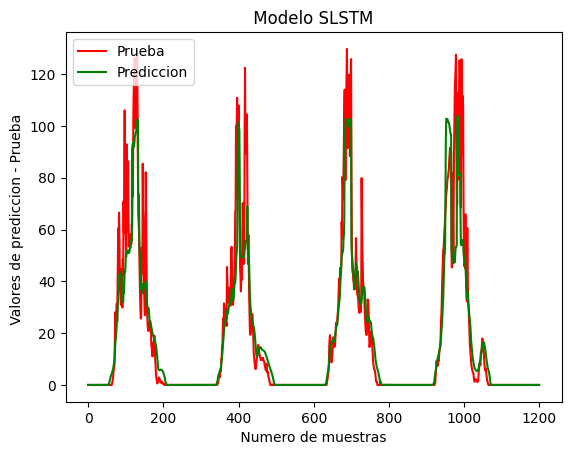

In [33]:
y_test_par = y_test[200:1400]
y_pred_slstm_par = y_pred_slstm[200:1400]


#Predicción temporal
plt.plot(y_test_par ,c='r')
plt.plot(y_pred_slstm_par ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo SLSTM ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()


In [34]:
print(f'MAE: {MAE_SLSTM}')
print(f'MSE: {MSE_SLSTM}')
print(f'r2: {r2_SLSTM}')

MAE: 4.966843499397857
MSE: 109.35065666867634
r2: 0.9001559667568018


# Predicciones con los diferentes modelos: Convolucional NN

# Busqueda de hyperparametros con el modelo: CNN

In [19]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime, os

def build_regressor_cnn(hp):
    model = keras.Sequential()

    for i in range(hp.Int("num_layers", 1, 1)):
        model.add(
            layers.Conv1D(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                filters=hp.Int(f"conv_filter_{i}", min_value=32, max_value=128, step=16),
                kernel_size=hp.Choice(f"conv_kernel_{i}", values = [1,2]),
                activation=hp.Choice("activation", ["relu", "tanh"]),
                input_shape = (X_train_std.shape[1], 1)
            )
        )

    for i in range(hp.Int("num_layers", 1, 1)):
        model.add(
            layers.MaxPooling1D(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                pool_size=hp.Int(f"cov_pool_size_{i}", min_value=1, max_value=2, step=1),
            )
        )

    model.add(Flatten())

    #model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(X_train_std.shape[1], 1)))

    for i in range(hp.Int("num_layers", 1, 1)):
        model.add(
            layers.Dense(
                # Se prueba el numero de neuronas desde 32 a 512 en pasos de 32
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1))
  
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model


build_regressor_cnn(keras_tuner.HyperParameters())

tuner_cnn = keras_tuner.RandomSearch(
    hypermodel=build_regressor_cnn,
    objective="val_mean_absolute_error",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="dir_cnn",
    project_name="cnn_training",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard("/cnn/tb_logs", histogram_freq=1)

tuner_cnn.search(X_train_std, y_train_std, validation_data=(X_test_std, y_test_std), batch_size=32, epochs=100, verbose=True, callbacks=[keras.callbacks.TensorBoard("/cnn/tb_logs")] )

tuner_cnn.search_space_summary()






Trial 3 Complete [00h 05m 32s]
val_mean_absolute_error: 4.243357181549072

Best val_mean_absolute_error So Far: 4.243357181549072
Total elapsed time: 00h 09m 25s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1, 'step': 1, 'sampling': 'linear'}
conv_filter_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_kernel_0 (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
cov_pool_size_0 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'de

In [20]:
tuner_cnn.results_summary()


Results summary
Results in dir_cnn\cnn_training
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 2 summary
Hyperparameters:
num_layers: 1
conv_filter_0: 112
conv_kernel_0: 1
activation: tanh
cov_pool_size_0: 1
units_0: 384
dropout: False
lr: 0.0033585758677651704
Score: 4.243357181549072

Trial 1 summary
Hyperparameters:
num_layers: 1
conv_filter_0: 32
conv_kernel_0: 2
activation: relu
cov_pool_size_0: 1
units_0: 96
dropout: True
lr: 0.0031262739522834224
Score: 4.771408557891846

Trial 0 summary
Hyperparameters:
num_layers: 1
conv_filter_0: 32
conv_kernel_0: 2
activation: tanh
cov_pool_size_0: 2
units_0: 128
dropout: True
lr: 0.0029594770617025457
Traceback (most recent call last):
  File "c:\Users\Fernando Jacome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Fernando Jacome\AppData

In [22]:
# Se obtiene los 2 mejores modelos encontrados
models_cnn = tuner_cnn.get_best_models(num_models=2)
best_model_cnn = models_cnn[0]
# Ejecuta el modelo
best_model_cnn.build(input_shape=(None, 28, 28))
best_model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 112)            224       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 112)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 384)               86400     
                                                                 
 dense_1 (Dense)             (None, 1)                 385       
                                                                 
Total params: 87,009
Trainable params: 87,009
Non-trainable params: 0
____________________________________________________

In [23]:
# Carga de la extension para tensordoard
%load_ext tensorboard

%tensorboard --logdir "/cnn/tb_logs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19080), started 0:58:01 ago. (Use '!kill 19080' to kill it.)

# Predicciones con el mejor modelo encontrado: Convolucional NN

In [24]:
y_pred_cnn = best_model_cnn.predict(X_test_std)
y_pred_cnn[y_pred_cnn < 0] = 0 

y_test = y_test.flatten() #flatten convierte vector a 1D para evitar problemas en el ploteo de las imágenes
y_pred_cnn = y_pred_cnn.flatten()

123/123 [==============================] - 0s 1ms/step


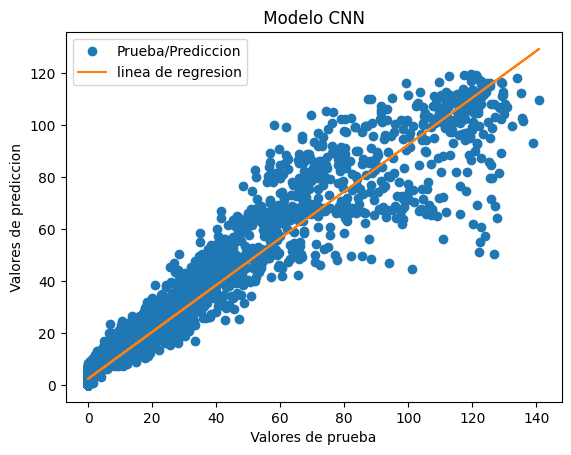

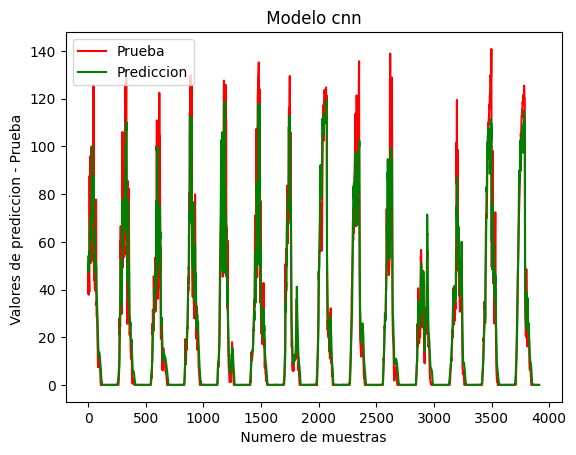

In [25]:
# Obtención de las métricas, Scatter plot y grafico temporal para CNN
# Las métricas seran: MAE, MSE y r^2
from sklearn import metrics
import matplotlib.pyplot as plt

mtrc = {
    'MAE': lambda y_true, y_pred: metrics.mean_absolute_error(y_true, y_pred), 
    'MSE': lambda y_true, y_pred: metrics.mean_squared_error(y_true, y_pred),
    'r2': lambda y_true, y_pred: metrics.r2_score(y_true, y_pred)
}


MAE_CNN = mtrc['MAE'](y_test, y_pred_cnn)

MSE_CNN = mtrc['MSE'](y_test, y_pred_cnn)

r2_CNN = mtrc['r2'](y_test, y_pred_cnn)


## cnn
#Sscatterplot
plt.plot( y_test, y_pred_cnn , 'o')  # Visualizacion del valor predecido y del valorde test
# Obtencion de la línea de regresión del scatterplot (pendiente e intercepto)
m, b = np.polyfit(y_test, y_pred_cnn, 1)
#La siguiente línea de código añade la línea de regresión lineal al scatterplot 
plt.plot(y_test, m*y_test+b)
plt.xlabel(' Valores de prueba ')   
plt.ylabel(' Valores de prediccion ') 
plt.title(' Modelo CNN ')
plt.legend (["Prueba/Prediccion", "linea de regresion"], loc="best", facecolor="w", fontsize=10)         
plt.show()

#Predicción temporal
plt.plot(y_test ,c='r')
plt.plot(y_pred_cnn ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo cnn ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()


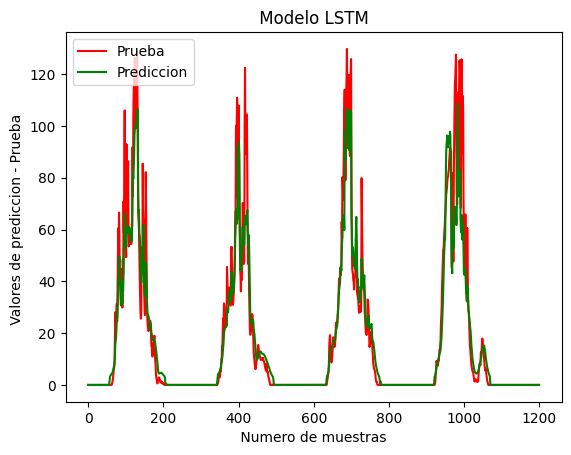

In [ ]:
y_test_par = y_test[200:1400]
y_pred_cnn_par = y_pred_cnn[200:1400]


#Predicción temporal
plt.plot(y_test_par ,c='r')
plt.plot(y_pred_cnn_par ,c='g')
plt.xlabel(' Numero de muestras ')   
plt.ylabel(' Valores de prediccion - Prueba  ') 
plt.title(' Modelo CNN ')
plt.legend (["Prueba", "Prediccion"], loc="best", facecolor="w", fontsize=10)               
plt.show()

In [26]:
print(f'MAE: {MAE_CNN}')
print(f'MSE: {MSE_CNN}')
print(f'r2: {r2_CNN}')

MAE: 4.172415344948163
MSE: 72.2950946340786
r2: 0.9339900275694204


In [1]:
!jupyter nbconvert  Estimación_y_predicción_de_Potencia_fotovoltaico_FernandoJacome_DAS.ipynb --to html

[NbConvertApp] Converting notebook Estimación_y_predicción_de_Potencia_fotovoltaico_FernandoJacome_DAS.ipynb to html
[NbConvertApp] Writing 2170039 bytes to Estimación_y_predicción_de_Potencia_fotovoltaico_FernandoJacome_DAS.html
